In [1]:
import numpy
%matplotlib notebook
from matplotlib import pyplot

In [2]:
from soapy import atmosphere, WFS, confParse
from aotools import circle
from aotools.wfs import wfslib

In [3]:
SOAPY_CONF = "conf/test_conf.py"

In [4]:
def scaleScrnR0(scrns, oldR0, newR0):
    r0Scrns = scrns.copy() * ((oldR0/newR0)**(5./6.))
    return r0Scrns

In [5]:
# Initialise the WFS
config = confParse.Configurator(SOAPY_CONF)
config.loadSimParams()

config.tel.telDiam=1.

mask = circle.circle(config.sim.pupilSize/2., config.sim.simSize)

wfs = WFS.ShackHartmann(
        config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)

In [6]:
# Make a set of phase screens to test
nScrns = 20
nSub = 4
scrnSize = config.sim.simSize*nSub
simSize = config.sim.simSize

# r0 to make scrns initially
scrn_r0 = 1.
pxlScale = 1./config.sim.pupilSize
L0 = 100
l0 = 0.01

# Make all the phase screens
scrns = numpy.zeros((nScrns*nSub*nSub, simSize, simSize))
for i in range(nScrns):
    wholeScrn = atmosphere.ft_sh_phase_screen(scrn_r0, scrnSize, pxlScale, L0, l0)
    for nx in range(nSub):
        for ny in range(nSub):
            index = i*(nSub**2) + nx*nSub + ny
            scrns[index] = wholeScrn[nx*simSize:(nx+1)*simSize, ny*simSize:(ny+1)*simSize]


In [7]:
scrns *= 500./(2*numpy.pi)
print(scrns.min(), scrns.max(), scrns.var())

(-786.52196296227862, 583.2904389314657, 30434.922612534781)


In [8]:
# Get slopes for each screen, for each r0
nR0 = 10
r0s = numpy.linspace(0.05, scrn_r0, nR0)
slopes = numpy.zeros((nR0, len(scrns), wfs.activeSubaps*2))

for ir, r0 in enumerate(r0s):
    r0Scrns = scaleScrnR0(scrns, 1, r0)
    print(r0, r0Scrns.var())
    for i, s in enumerate(r0Scrns):
        slopes[ir, i] = wfs.frame(s)

(0.050000000000000003, 4484928.5425304286)
(0.15555555555555556, 676440.58751546009)
(0.26111111111111113, 285318.509811836)
(0.36666666666666664, 162026.66179455104)
(0.47222222222222221, 106282.43621400738)
(0.57777777777777783, 75934.209846950936)
(0.68333333333333335, 57409.600480220506)
(0.78888888888888897, 45186.891846274775)
(0.89444444444444449, 36653.595568484547)
(1.0, 30434.922612534781)


In [9]:
for i in range(nR0):
    print(slopes[i].min(), slopes[i].max(), slopes[i].var())

(-2.4841111943053305, 2.6405898218561799, 0.39394853937976426)
(-0.97636931334947796, 1.0386697009227479, 0.063626165789563344)
(-0.65435493803958877, 0.67339418578276167, 0.028730363961117847)
(-0.45001090613668104, 0.49291010370250454, 0.017296724153929636)
(-0.40615338142471025, 0.41401064328904091, 0.011780650036102232)
(-0.32629855479141234, 0.33327967671389835, 0.0086331061817657585)
(-0.29391032605210654, 0.30159993411206365, 0.0066370894544104976)
(-0.26702797342495721, 0.27497575692185627, 0.0052828720279083788)
(-0.24457796781337748, 0.25253971046436519, 0.004319219856422943)
(-0.22564116765696163, 0.2334853497455196, 0.0036072795505794463)


In [10]:
# Turn slopes into radians
wfsPxlScale_asec = float(config.wfss[0].subapFOV)/config.wfss[0].pxlsPerSubap
wfsPxlScale_deg = wfsPxlScale_asec/3600.
wfsPxlScale_rad = wfsPxlScale_deg * (numpy.pi/180.)
print(wfsPxlScale_rad)

6.06017101387e-07


In [11]:
# Convert slopes to rad
slopes_rad = slopes*wfsPxlScale_rad

In [12]:
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros(nR0)
for i in range(nR0):
    sVar = slopes_rad[i].var(0).mean()
    measuredR0[i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 6e-07
Subap Diameter (m): 1.0


<IPython.core.display.Javascript object>


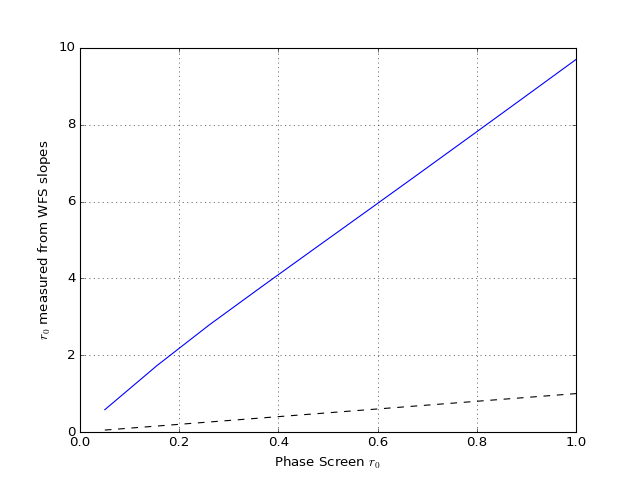

In [13]:
pyplot.figure()
pyplot.plot(r0s, measuredR0)
pyplot.plot(r0s, r0s, color="k", linestyle="--")
pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

In [14]:
slopes_rad[1].var(0).mean()

2.3310180392350084e-14

In [15]:
wfs.activeSubaps

52

In [16]:
nScrns = 100

# Alternative way, which uses Soapy atmosphere
config.atmos.scrnNo = 1
slopes = numpy.zeros((nR0, nScrns, wfs.activeSubaps*2))
for ir, r0 in enumerate(r0s):
    config.atmos.r0 = r0
    config.atmos.randomScrns = True
    atmos = atmosphere.atmos(config.sim, config.atmos)
    for i in range(nScrns):
        slopes[ir, i] = wfs.frame(atmos.moveScrns())

In [17]:
slopes.shape

(10, 100, 104)

In [18]:
# Convert slopes to rad
slopes_rad = slopes*wfsPxlScale_rad
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros(nR0)
for i in range(nR0):
    sVar = slopes_rad[i].var(0).mean()
    measuredR0[i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 6e-07
Subap Diameter (m): 1.0


<IPython.core.display.Javascript object>


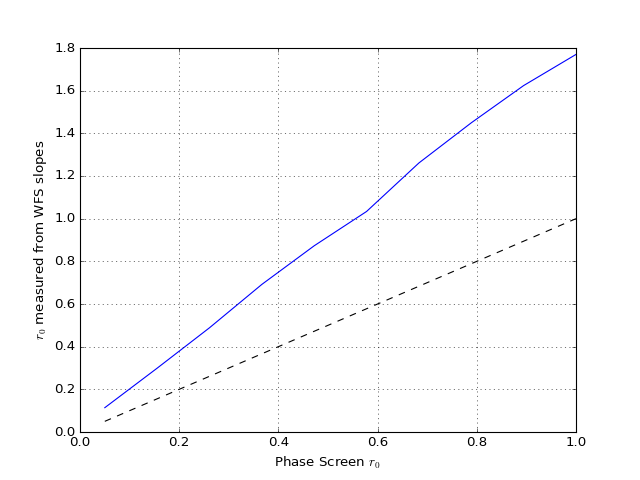

In [19]:
pyplot.figure()
pyplot.plot(r0s, measuredR0)
pyplot.plot(r0s, r0s, color="k", linestyle="--")
pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

In [20]:
# Perhaps this is something to do with WFS linearity? Would see a change with pixel scale if so
nFovs = 5
subapFovs = numpy.linspace(3, 10, nFovs)
nScrns = 100

# Alternative way, which uses Soapy atmosphere
config.atmos.scrnNo = 1

slopes = numpy.zeros((nFovs, nR0, nScrns, wfs.activeSubaps*2))

for ifov, fov in enumerate(subapFovs):
    config.wfss[0].subapFOV = fov
    wfs = WFS.ShackHartmann(
            config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)
    for ir, r0 in enumerate(r0s):
        config.atmos.r0 = r0
        config.atmos.randomScrns = True
        atmos = atmosphere.atmos(config.sim, config.atmos)
        for i in range(nScrns):
            slopes[ifov, ir, i] = wfs.frame(atmos.moveScrns())

WFS.py -> initFFTs: requested WFS FFT Padding less than FOV size... Setting oversampling to: 4
WFS.py -> initFFTs: requested WFS FFT Padding less than FOV size... Setting oversampling to: 5


In [21]:
wfsPxlScales_rad = []
slopes_rad = slopes.copy()
# Turn slopes into radians
for ifov, fov in enumerate(subapFovs):
    wfsPxlScale_asec = float(fov)/config.wfss[0].pxlsPerSubap
    wfsPxlScale_deg = wfsPxlScale_asec/3600.
    wfsPxlScale_rad = wfsPxlScale_deg * (numpy.pi/180.)
    
    slopes_rad[ifov] *= wfsPxlScale_rad
    print(wfsPxlScale_rad)

7.27220521664e-07
1.15143249264e-06
1.57564446361e-06
1.99985643458e-06
2.42406840555e-06


In [22]:
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = wfs.subapDiam
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros((nFovs, nR0))
for ifov, fov in enumerate(subapFovs):
    for i in range(nR0):
        sVar = slopes_rad[ifov, i].var(0).mean()
        measuredR0[ifov, i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 6e-07
Subap Diameter (m): 1.0


<IPython.core.display.Javascript object>


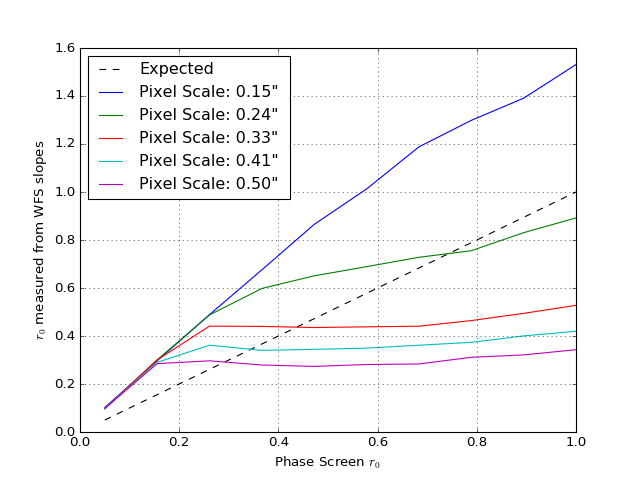

In [23]:
pyplot.figure()
pyplot.plot(r0s, r0s, color="k", linestyle="--", label="Expected")

pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

for ifov, fov in enumerate(subapFovs):
    pxlScale = float(fov)/config.wfss[0].pxlsPerSubap
    pyplot.plot(r0s, measuredR0[ifov], label="Pixel Scale: {:.2f}\" ".format(pxlScale))
    
pyplot.legend(loc=0)